In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import sys

from tqdm.notebook import tqdm_notebook as tqdm

sys.path.append("..")

from utils.logger import tick
from core import DomainMeta, SimulationMeta, FluidMeta, D2Q9, CellType
from ics import vortex
from vtkio import write_vti

In [3]:
# params
# dom = DomainMeta.with_extent_and_counts(extent=[[-1, 1], [-1, 1.1]], counts=[200, 220])
dom = DomainMeta.with_extent_and_counts(extent=[[-2, 2], [-2, 2]], counts=[400, 400])
fld = FluidMeta(mu=0.001, rho=1000)
# sim = SimulationMeta(domain=dom, fluid=fld, dt=0.0001)
sim = SimulationMeta(domain=dom, fluid=fld, dt=0.001)

print(f"{dom.dx=}, {dom.extent=}, {dom.counts=}, cells={np.prod(dom.counts):,d}")
print(f"{fld.mu=}, {fld.rho=}, {fld.nu=}")
print(f"{sim.tau=}, {sim.c=}")

dom.dx=0.01, dom.extent=array([[-2,  2],
       [-2,  2]]), dom.counts=array([400, 400], dtype=int32), cells=160,000
fld.mu=0.001, fld.rho=1000, fld.nu=1e-06
sim.tau=0.50003, sim.c=10.0


In [37]:
# initialize arrays
f = dom.make_array(9)
v = dom.make_array(2)
cell = dom.make_array(dtype=np.int8)
rho = dom.make_array(fill=fld.rho)
curl = dom.make_array()
feq = np.zeros_like(f)

xx, yy = np.meshgrid(dom.x, dom.y, indexing="ij")

# --- Vortex collision

# vx = np.zeros_like(xx)
# vy = np.zeros_like(xx)
#
# s_v = 0.05 * sim.c
# dy_v = 0.2
# dx_v = 0.4
# for x_v, y_v, vx_v, c in [
#     (-dx_v / 2, dy_v / 2, s_v, False),
#     (-dx_v / 2, -dy_v / 2, s_v, True),
#     (dx_v / 2, dy_v / 2, -s_v, True),
#     (dx_v / 2, -dy_v / 2, -s_v, False),
# ]:
#     vx_, vy_ = vortex(xx, yy, x_v, y_v, vx_v, 0, 0.1 * sim.c, 0.1, c)
#     vx += vx_
#     vy += vy_
#
# v = np.stack([vx, vy], -1)


vmax = np.sqrt(np.max(np.sum(v**2, -1)))
print(f"{vmax=}")

# --- Cylinder
cell[:, :] = CellType.BC_WALL.value * (((xx - 0) ** 2 + (yy - 0.0) ** 2) < 0.2**2.0)

# --- In-flow jet
cell[1, :150] = CellType.BC_WALL.value
cell[1, -150:] = CellType.BC_WALL.value
cell[1, 150:-150] = CellType.FIXED_VELOCITY.value
v[:, 150:-150, 0] = sim.c * 0.1

vmax=0.0


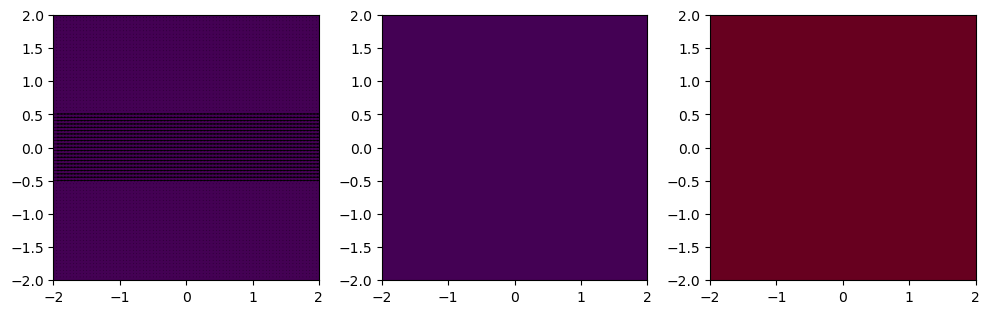

In [38]:
def plot(t: int, path: str | None = None):
    s = slice(1, -1, 5)
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2, sharey=ax1)
    ax3 = fig.add_subplot(1, 3, 3, sharey=ax1)
    im_kwargs = {
        "interpolation": "nearest",
        "origin": "lower",
        "extent": dom.extent.flatten(),
    }
    ax1.imshow(
        np.sqrt(np.sum(v**2, -1))[1:-1, 1:-1].T,
        **im_kwargs,
        vmax=vmax,
    )
    ax1.quiver(xx[s, s], yy[s, s], v[s, s, 0], v[s, s, 1])
    ax2.imshow(
        rho[1:-1, 1:-1].T,
        **im_kwargs,
    )  # , vmin=rho_*0.99, vmax=rho_*1.01)
    ax3.imshow(
        curl[1:-1, 1:-1].T,
        **im_kwargs,
        cmap=plt.cm.RdBu,
    )
    # fig.suptitle(f"$t={t}$")
    fig.tight_layout()

    if path is None:
        plt.show()
        return

    fig.savefig(path, dpi=300)
    fig.clear()
    plt.close()
    return


plot(-1)

In [39]:
write_vti(f"out/example1_{0:06d}.vti", dom, v, rho, curl, cell)

In [40]:
wall = 1 * (cell == CellType.BC_WALL.value)
update_vel = 1 * (cell == CellType.FLUID.value)[:, :, np.newaxis]

# main loop
t = 0.0
out_dt = 0.01
out_i = 1
out_t = out_dt
max_i = 300

perf = tick()
try:
    for t in tqdm(np.arange(0, max_i * out_dt, sim.dt)):

        # equillibrium
        vv = np.sum(v * v, -1)
        for i, (w, q) in enumerate(zip(D2Q9.ws, D2Q9.qs)):
            qv = np.sum(q * v, -1)
            feq[:, :, i] = (
                rho
                * w
                * (1 + 3.0 * qv / sim.c**1 + 4.5 * qv**2 / sim.c**2 - (3.0 / 2.0) * vv / sim.c**2)
            )

            if np.any(~np.isfinite(qv)) or np.any(~np.isfinite(vv)):
                raise ValueError(f"{i}, {q}")

        if t < sim.dt:
            f = feq

        # collide
        f += (feq - f) / sim.tau

        # periodic
        f[0, :, :], f[-1, :, :] = f[-2, :, :], f[1, :, :]
        f[:, 0, :], f[:, -1, :] = f[:, -2, :], f[:, 1, :]

        # stream
        for i, (w, q, j) in enumerate(zip(D2Q9.ws, D2Q9.qs, D2Q9.js)):
            sx_up = slice(1 - q[0], dom.counts[0] + 1 - q[0])
            sy_up = slice(1 - q[1], dom.counts[1] + 1 - q[1])
            sx_dn = slice(1 + q[0], dom.counts[0] + 1 + q[0])
            sy_dn = slice(1 + q[1], dom.counts[1] + 1 + q[1])
            feq[1:-1, 1:-1, i] = (
                f[sx_up, sy_up, i] * (1 - wall[sx_up, sy_up])  # stream
                + f[1:-1, 1:-1, j] * wall[sx_up, sy_up]  # bounceback
            )

        # swap
        f, feq = feq, f

        # macroscopic
        rho = np.sum(f, -1)
        v = update_vel * (f @ D2Q9.qs) * sim.c / rho[:, :, None] + (1 - update_vel) * v
        curl[1:-1, 1:-1] = v[2:, 1:-1, 1] - v[0:-2, 1:-1, 1] - (v[1:-1, 2:, 0] - v[1:-1, 0:-2, 0])
        curl /= 2 * dom.dx

        perf.add_events(np.prod(dom.counts))
        # plot(t)
        # save
        if t >= out_t:
            # plot(t, f"./out/example1_{out_i:06d}.png")
            print(f"Wrote {out_i=} {out_t=:.3f}\r")
            write_vti(f"out/example1_{out_i:06d}.vti", dom, v, rho, curl, cell)
            out_i += 1
            out_t += out_dt

            if out_i > max_i:
                break

finally:
    perf = perf.tock()
    mlup = perf.events / 1e6
    print(f"{mlup / perf.seconds:,.1f} MLUP/s")

  0%|          | 0/3000 [00:00<?, ?it/s]

Wrote out_i=1 out_t=0.010
Wrote out_i=2 out_t=0.020
Wrote out_i=3 out_t=0.030
Wrote out_i=4 out_t=0.040
Wrote out_i=5 out_t=0.050
Wrote out_i=6 out_t=0.060
Wrote out_i=7 out_t=0.070
Wrote out_i=8 out_t=0.080
Wrote out_i=9 out_t=0.090
Wrote out_i=10 out_t=0.100
Wrote out_i=11 out_t=0.110
Wrote out_i=12 out_t=0.120
Wrote out_i=13 out_t=0.130
Wrote out_i=14 out_t=0.140
Wrote out_i=15 out_t=0.150
Wrote out_i=16 out_t=0.160
Wrote out_i=17 out_t=0.170
Wrote out_i=18 out_t=0.180
Wrote out_i=19 out_t=0.190
Wrote out_i=20 out_t=0.200
Wrote out_i=21 out_t=0.210
Wrote out_i=22 out_t=0.220
Wrote out_i=23 out_t=0.230
Wrote out_i=24 out_t=0.240
Wrote out_i=25 out_t=0.250
Wrote out_i=26 out_t=0.260
Wrote out_i=27 out_t=0.270
Wrote out_i=28 out_t=0.280
Wrote out_i=29 out_t=0.290
Wrote out_i=30 out_t=0.300
Wrote out_i=31 out_t=0.310
Wrote out_i=32 out_t=0.320
Wrote out_i=33 out_t=0.330
Wrote out_i=34 out_t=0.340
Wrote out_i=35 out_t=0.350
Wrote out_i=36 out_t=0.360
Wrote out_i=37 out_t=0.370
Wrote out_

In [9]:
# import subprocess as sp
# sp.call("ffmpeg -r 10 -i out/example1_%06d.png -c:v libx264 -crf 0 -y example1.mp4 ", shell=True)

/root/anaconda3/envs/boltzmann/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


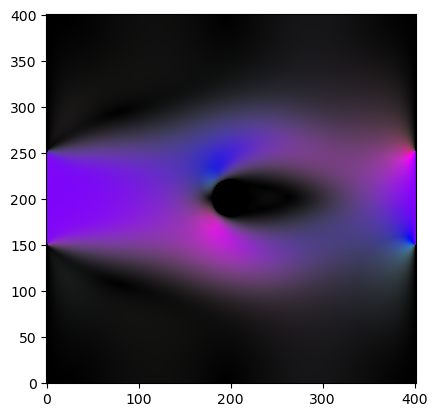

In [41]:
import colorsys as clr

theta = np.arctan2(v[:, :, 0], v[:, :, 1])
theta = (theta / np.pi + 1) / 2
r = np.sqrt(np.sum(v**2, -1))


rgb = np.zeros((v.shape[0], v.shape[1], 3))
for i in range(v.shape[0]):
    for j in range(v.shape[1]):
        vm = np.clip(r[i, j] / np.max(r), 0, 1)
        rgb[i, j, :] = clr.hsv_to_rgb(theta[i, j], vm, vm)
        if wall[i, j] > 0:
            rgb[i, j, :] = np.nan

plt.imshow(np.transpose(rgb, (1, 0, 2)), origin="lower")